# 코로나 네이버 뉴스 API 분석

# 네이버 뉴스 크롤링

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import sys
import urllib.request
import json
client_id = "16Q9VECLiTyUuiSRoJDr"
client_secret = "p1wsZa60YG"

# 함수 설계
def getRequestURL(url):
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    try:
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if(rescode==200):
            response_body = response.read()
            return response_body.decode('utf-8')
        else:
            print("Error Code:" + rescode)
            return None
    except Exception as e:
        print(e)
        return None

def getNaverSearch(srcText, searchType='news', display=10, start=1):
    encText = urllib.parse.quote(srcText)
    url = f"https://openapi.naver.com/v1/search/{searchType}.json?query={encText}&display={display}&start={start}&sort=sim"
    jsonData = getRequestURL(url)
    if jsonData == None:
        return None
    else:
        return json.loads(jsonData)

In [3]:
searchRange = [i for i in range(1, 1000, 100)] + [1000]
result = []
for start in searchRange:
    result += getNaverSearch('코로나', start = start, display=100)['items']

In [4]:
result

[{'title': '“<b>코로나</b> 백신, 고위험군 年2회 접종을”',
  'originallink': 'https://www.donga.com/news/Society/article/all/20230207/117782202/1',
  'link': 'https://n.news.naver.com/mnews/article/020/0003478278?sid=102',
  'description': '지영미 질병관리청장이 앞으로 “신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19) 백신을 연 1, 2회 정례적으로 접종하는 것이 합리적이다”라고 밝혔다. <b>코로나</b>19가 팬데믹(대유행)에서 엔데믹(풍토병화)으로 전환되면서... ',
  'pubDate': 'Wed, 08 Feb 2023 03:03:00 +0900'},
 {'title': '방역당국 &quot;<b>코로나</b>백신 정례접종, 변이예측·백신개발 보며 검토&quot;',
  'originallink': 'https://www.yna.co.kr/view/AKR20230208082800530?input=1195m',
  'link': 'https://n.news.naver.com/mnews/article/001/0013744485?sid=102',
  'description': '방역 당국이 <b>코로나</b>19 백신의 정례접종 도입을 검토할 때 변이 예측, 백신 개발 상황 등을 고려할 것이라고 밝혔다. 임숙영 중앙방역대책본부(방대본) 상황총괄단장은 8일 브리핑에서 &quot;정례적인 접종이 추진되기 위해서는... ',
  'pubDate': 'Wed, 08 Feb 2023 12:03:00 +0900'},
 {'title': '방역당국 &quot;<b>코로나</b> 백신 연 1~2회 정기접종 검토 중&quot;',
  'originallink': 'https://news.jtbc.co.kr/article/article.aspx?news_id=NB12113955',
  'link':

### 분석에 필요한 데이터 추출

In [5]:
data_title = []
data_description = []
for item in result:
    data_title.append(item['title'])
    data_description.append(item['description'])

In [6]:
data_df = pd.DataFrame({'title':data_title, 'description':data_description})

In [7]:
data_df.head()

,title,description
0,"“<b>코로나</b> 백신, 고위험군 年2회 접종을”",지영미 질병관리청장이 앞으로 “신종 <b>코로나</b>바이러스 감염증(<b>코로나<...
1,"방역당국 &quot;<b>코로나</b>백신 정례접종, 변이예측·백신개발 보며 검토&...","방역 당국이 <b>코로나</b>19 백신의 정례접종 도입을 검토할 때 변이 예측, ..."
2,방역당국 &quot;<b>코로나</b> 백신 연 1~2회 정기접종 검토 중&quot;,방역당국이 <b>코로나</b>19 변이 예측과 백신 개발 상황 등을 고려해 백신 정...
3,폐업신고 않고 매출실적 낮춰 <b>코로나</b> 지원금 ‘꿀꺽’,특히 <b>코로나</b>19 소상공인 지원금 부정수급 신고 관련 상담이 1년 전보다...
4,"&apos;<b>코로나</b> 수혜&apos; 줌, 직원 1300명 감원 발표",<b>코로나</b>19 팬데믹 대표 수혜 기업 중 하나인 화상회의 업체 줌 비디오 ...


# title에 대한 감성 분석
### 감성분석을 실시할 데이터의 피처 벡터화
### 감성분석 - 로지스틱회귀 - 파라메터는 하이터 튜닝
### 결과를 프레임에 저장

In [8]:
from konlpy.tag import Okt
okt = Okt()
def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)

In [9]:
tfidf.fit(data_df['title'])
data_title_tfidf = tfidf.transform(data_df['title'])

C:\Users\user\miniconda3\envs\py\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [10]:
data_title_tfidf.shape

(1100, 1626)

In [13]:
train_df = pd.read_csv('https://raw.githubusercontent.com/leekyuyoung20221226/python/main/data/ratings_train.txt', encoding='utf-8', sep='\t')
train_df.dropna(subset=['document'],axis=0, inplace=True)
train_df.reset_index(drop=True, inplace=True)
import re
train_df['document'] = train_df['document'].apply(lambda x: re.sub(r'[^ㄱ-ㅎ가-힣]+', " ", x))
train_tfidf = tfidf.transform(train_df['document'])

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(random_state=0)
param = {
    'C':range(1,10)
}
gsc = GridSearchCV(lr, param_grid=param, cv=3, scoring='accuracy', verbose=1)
gsc.fit(train_tfidf, train_df['label'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\user\miniconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\miniconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': range(1, 10)}, scoring='accuracy', verbose=1)

In [17]:
gsc.best_params_

{'C': 4}

In [18]:
import pickle
pickle.dump(gsc.best_estimator_, open('logistic_tfidf.sav', 'wb'))

In [19]:
loaded_lr = pickle.load(open('logistic_tfidf.sav', 'rb'))

In [20]:
data_df['title_label'] = loaded_lr.predict(data_title_tfidf)

In [21]:
data_df_tfidf = tfidf.transform(data_df['description'])
data_df['description_label'] = loaded_lr.predict(data_df_tfidf)

In [22]:
data_df.head()

,title,description,title_label,description_label
0,"“<b>코로나</b> 백신, 고위험군 年2회 접종을”",지영미 질병관리청장이 앞으로 “신종 <b>코로나</b>바이러스 감염증(<b>코로나<...,0,0
1,"방역당국 &quot;<b>코로나</b>백신 정례접종, 변이예측·백신개발 보며 검토&...","방역 당국이 <b>코로나</b>19 백신의 정례접종 도입을 검토할 때 변이 예측, ...",0,0
2,방역당국 &quot;<b>코로나</b> 백신 연 1~2회 정기접종 검토 중&quot;,방역당국이 <b>코로나</b>19 변이 예측과 백신 개발 상황 등을 고려해 백신 정...,1,0
3,폐업신고 않고 매출실적 낮춰 <b>코로나</b> 지원금 ‘꿀꺽’,특히 <b>코로나</b>19 소상공인 지원금 부정수급 신고 관련 상담이 1년 전보다...,0,0
4,"&apos;<b>코로나</b> 수혜&apos; 줌, 직원 1300명 감원 발표",<b>코로나</b>19 팬데믹 대표 수혜 기업 중 하나인 화상회의 업체 줌 비디오 ...,0,0


In [24]:
data_df['title_label'].value_counts(), data_df['description_label'].value_counts()

(0    794
 1    306
 Name: title_label, dtype: int64,
 0    871
 1    229
 Name: description_label, dtype: int64)

In [25]:
data_df.to_csv('코로나네이버뉴스api감성분석.csv', encoding='utf-8')

# 결과
    title 분석 결과와 description 분석 결과에 차이가 있음
    단어를 기준으로 분석하기 때문에 단어의 개수가 부족하면 정확도가 떨어진다

# 검성분석 결과를 분리 저장

In [29]:
# import copy
# negative_df = copy.deepcopy(data_df)
# positive_df = copy.deepcopy(data_df)
# col_names = ['title', 'title_label', 'description', 'description_label']
# negative_df = pd.DataFrame(columns=col_names)
# positive_df = pd.DataFrame(columns=col_names)
negative_df = copy.deepcopy(data_df[data_df['description_label'] == 0])
positive_df = copy.deepcopy(data_df[data_df['description_label'] == 1])

In [30]:
negative_df.shape, positive_df.shape

((871, 4), (229, 4))

# 결과 시각화

In [31]:
positive_df['description']

16      7%↑)…당기순이익 5050억원 신세계인터내셔날, 센트럴시티 등 자회사 성장세 [서...
22      기사내용 요약 승승장구해 온 K김치, 작년수출액 7년 만에 감소 &quot;<b>코...
32      <b>코로나</b>19 대유행 때 6개월 만에 주가가 1079% 뛴 어느 ‘<b>코...
37      방역당국은 신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19) 백신을 ...
39      경북에서 <b>코로나</b>19 확진자 959명이 새로 나왔다. 8일 경북도에 따르...
                              ...                        
1065    상씨는 &quot;5년 전부터 영업을 시작했는데 <b>코로나</b> 때문에 계속 힘...
1071    <b>코로나</b>19에 감염된 뒤 재감염되는 데 걸리는 기간이 반년 만에 5개월에...
1073    <b>코로나</b>19 사태 이후 골프 인구가 크게 성장한 가운데 MZ세대(밀레니얼...
1078    건강보험심사평가원 자료 기반, 국내 뇌염 환자 분석 신종 <b>코로나</b>바이러스...
1094                                                아주경제=
Name: description, Length: 229, dtype: object

In [33]:
from konlpy.tag import Okt
okt = Okt()
positive_description_noun_tk = []
for word in positive_df['description']:
    positive_description_noun_tk.append(okt.nouns(word))

In [34]:
positive_result = []
for listdata in positive_description_noun_tk:
    temp = [w for w in listdata if len(w) > 1]
    positive_result.append(" ".join(temp))

In [41]:
negative_description_noun_tk = []
for word in negative_df['description']:
    negative_description_noun_tk.append(okt.nouns(word))

In [38]:
from functools import reduce
negative_description_noun_tk = reduce(lambda x,y: x+y, negative_description_noun_tk)

In [42]:
negative_result = []
for listdata in negative_description_noun_tk:
    temp = [w for w in listdata if len(w) > 1]
    negative_result.append(" ".join(temp))
negative_result = [w for w in negative_result if w != ' ']
negative_result[:5]

['지영미 질병 관리 청장 신종 코로나 바이러스 감염증 코로나 백신 정례 접종 합리 코로나 팬데믹 대유행 엔데믹 풍토병 전환',
 '방역 당국 코로나 백신 정례 접종 도입 검토 예측 백신 개발 상황 고려 임숙영 중앙 방역 대책 본부 대본 상황 총괄 단장 브리핑 정례 접종 추진',
 '방역 당국 코로나 예측 백신 개발 상황 고려 백신 정례 접종 검토 앞서 지영미 질병 관리 청장 전날 취임 기자간담회 코로나 백신 정례 접종 언급',
 '코로나 소상 공인 원금 부정 수급 신고 관련 상담 전보 급증 국민권익위 코로나 소상 공인 원금 부정 수급 신고 관련 상담 권익위 관계자',
 '코로나 팬데믹 대표 수혜 기업 하나 화상회의 업체 비디오 커뮤니케이션 현지 시간 에릭 위안 최고경영자 블로그 통해 코로나 대유행 이후 세계 계속 회사']

In [43]:
pos_tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, min_df=2)
pos_dtm = pos_tfidf.fit_transform(positive_result)

In [46]:
pos_vocab = {}
for idx, word in enumerate(pos_tfidf.get_feature_names()):
    pos_vocab[word] = pos_dtm.getcol(idx).sum()

In [47]:
pos_vocab

{'가까이': 0.7472761301097636,
 '가동': 1.724869541617739,
 '가스': 0.6770016836319117,
 '가운데': 2.2874730808390447,
 '가장': 2.3209716168552976,
 '가정': 0.535598328859544,
 '가족': 1.0375439371665833,
 '가지': 0.6983300765553022,
 '각각': 1.0663655825206633,
 '감소': 2.9403392892846987,
 '감염': 4.991453133145031,
 '감염병': 1.9250138843395779,
 '감염증': 4.715773131450582,
 '강행': 0.6365195943730408,
 '개방': 0.758169028329708,
 '개선': 1.358086801465988,
 '개월': 3.677975483225472,
 '개인': 1.0851064375748671,
 '개최': 0.7607505900517848,
 '거리': 1.3660410634694362,
 '건강': 1.3196923814238106,
 '건국절': 0.4054859164758635,
 '건수': 0.6341186277098392,
 '검사': 6.0471668442681725,
 '검토': 0.5053393081918827,
 '게시': 0.4929566223692359,
 '겨울': 0.5218608415509237,
 '격리': 1.019610116026099,
 '결과': 1.8857456373158288,
 '결정': 0.6846089726147577,
 '경계': 1.4253991014514413,
 '경기': 0.57636451149887,
 '경북': 1.9232677004426402,
 '경우': 0.8782306341507604,
 '경제': 0.8364493853677493,
 '경찰': 0.5830163372475436,
 '계속': 0.8588442382801953,
 '계층':

In [48]:
pos_word = sorted(pos_vocab.items(), key=lambda x: x[1], reverse=True)

In [49]:
pos_word

[('코로나', 24.850409049444206),
 ('진자', 11.423016863009911),
 ('재난', 8.164327595366693),
 ('문자', 8.060838741978966),
 ('이후', 7.131792695083709),
 ('신규', 6.798523989216903),
 ('지난', 6.469226559302031),
 ('검사', 6.0471668442681725),
 ('발생', 5.701850012938101),
 ('발송', 5.278170724078436),
 ('바이러스', 5.000590813488228),
 ('감염', 4.991453133145031),
 ('독감', 4.968238487753422),
 ('기준', 4.875233362846553),
 ('팬데믹', 4.831244200248147),
 ('세계', 4.8159351872000355),
 ('매일', 4.766585554399916),
 ('감염증', 4.715773131450582),
 ('최근', 4.673939695545295),
 ('기간', 4.535622318624999),
 ('접종', 4.48663802989081),
 ('통계', 4.4805099372866035),
 ('신종', 4.469952941858728),
 ('지난해', 4.2004161368330815),
 ('기자', 4.15583167123293),
 ('방역', 4.043070501892421),
 ('동시', 3.889612663279239),
 ('지난달', 3.830492816841899),
 ('진단', 3.7934886423582186),
 ('제품', 3.7861334499791526),
 ('허가', 3.6813288104197976),
 ('수젠텍', 3.6790146236299677),
 ('개월', 3.677975483225472),
 ('기업', 3.611747762440922),
 ('전날', 3.6024339082765273),
 ('

In [50]:
neg_tfidf = TfidfVectorizer(tokenizer=okt_tokenizer, min_df=2)
neg_dtm = neg_tfidf.fit_transform(negative_result)
neg_vocab = {}
for idx, word in enumerate(neg_tfidf.get_feature_names()):
    neg_vocab[word] = neg_dtm.getcol(idx).sum()
neg_word = sorted(neg_vocab.items(), key=lambda x: x[1], reverse=True)

In [51]:
neg_word

[('코로나', 84.85459605170126),
 ('진자', 53.20586234369132),
 ('신규', 34.841488746150745),
 ('중국', 30.870978574667475),
 ('방역', 30.611580669423333),
 ('접종', 30.485285628452083),
 ('대책', 27.47436587288088),
 ('중앙', 26.732228000166675),
 ('발생', 26.560669534168092),
 ('본부', 26.277324276310594),
 ('기준', 25.63708929359077),
 ('백신', 24.173261035589313),
 ('누적', 22.346153936718157),
 ('검사', 21.93154783879455),
 ('감소', 19.225230094217533),
 ('사태', 18.478774473115443),
 ('국내', 18.323412791226495),
 ('바이러스', 18.022698310915438),
 ('유아', 17.83860785866706),
 ('유행', 17.66151258311119),
 ('질병', 17.44438829416729),
 ('관리', 17.089657615681908),
 ('이후', 16.869774008026944),
 ('감염증', 16.869607086989177),
 ('감염', 16.71976395264522),
 ('대상', 16.482460158552133),
 ('이전', 16.365260828487106),
 ('신종', 16.2365770056701),
 ('입국', 16.15787544790748),
 ('정부', 15.801131635067573),
 ('지난', 15.68015162496451),
 ('지난해', 15.475288936448315),
 ('예방접종', 15.467303320597793),
 ('재난', 15.101022147572339),
 ('대응', 14.521514985

In [52]:
font_path = "C:/Windows/Fonts/HMKMMAG.TTF"
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [53]:
fm.get_fontconfig_fonts()
font_name = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font_name)

C:\Temp\ipykernel_32440\463655435.py:1: MatplotlibDeprecationWarning: The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


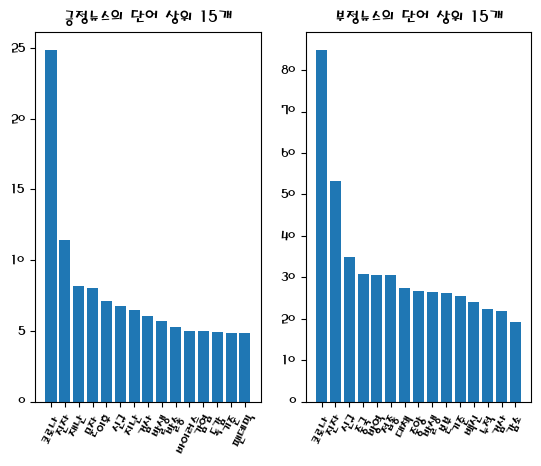

In [56]:
import seaborn as sns
plt.subplot(1,2,1)
plt.bar(range(15), [i[1] for i in pos_word[:15]])
plt.title('긍정뉴스의 단어 상위 15개')
plt.xticks(range(15), [i[0] for i in pos_word[:15]], rotation=65)

plt.subplot(1,2,2)
plt.bar(range(15), [i[1] for i in neg_word[:15]])
plt.title('부정뉴스의 단어 상위 15개')
plt.xticks(range(15), [i[0] for i in neg_word[:15]], rotation=65)
plt.show()

# 토픽 분석

In [57]:
data_df.to_csv('코로나 뉴스.csv', encoding='utf-8')

In [58]:
pd.read_csv('코로나 뉴스.csv', index_col=0)

,title,description,title_label,description_label
0,"“<b>코로나</b> 백신, 고위험군 年2회 접종을”",지영미 질병관리청장이 앞으로 “신종 <b>코로나</b>바이러스 감염증(<b>코로나<...,0,0
1,"방역당국 &quot;<b>코로나</b>백신 정례접종, 변이예측·백신개발 보며 검토&...","방역 당국이 <b>코로나</b>19 백신의 정례접종 도입을 검토할 때 변이 예측, ...",0,0
2,방역당국 &quot;<b>코로나</b> 백신 연 1~2회 정기접종 검토 중&quot;,방역당국이 <b>코로나</b>19 변이 예측과 백신 개발 상황 등을 고려해 백신 정...,1,0
3,폐업신고 않고 매출실적 낮춰 <b>코로나</b> 지원금 ‘꿀꺽’,특히 <b>코로나</b>19 소상공인 지원금 부정수급 신고 관련 상담이 1년 전보다...,0,0
4,"&apos;<b>코로나</b> 수혜&apos; 줌, 직원 1300명 감원 발표",<b>코로나</b>19 팬데믹 대표 수혜 기업 중 하나인 화상회의 업체 줌 비디오 ...,0,0
...,...,...,...,...
1095,"美, 5월 11일 &apos;<b>코로나</b>19 비상&apos; 종료 예정",미국 정부가 오는 5월 11일 <b>코로나</b>19로 인한 공중보건 비상사태를 종...,1,0
1096,"캐나다, 중국발 입국자 <b>코로나</b>19 의무 검사 두달 연장","캐나다가 중국, 홍콩, 마카오에서 입국한 여행객에 대한 <b>코로나</b>19 의무...",0,0
1097,"중국, 한국발 입국자에 <b>코로나</b> 검사…중국인은 제외",<b>코로나</b>19 검사를 예고대로 시행하면서 자국민은 제외한 외국 국적자에 대...,0,0
1098,[<b>코로나</b>19]부산 신규 확진 337명,부산시 방역당국은 오늘 0시 기준 부산지역 <b>코로나</b>19 신규 확진자는 3...,1,0
